# TransMorph-affine model

# Training

In [1]:
# Import packages

In [2]:
import os, utils, glob, losses
import sys
from torch.utils.data import DataLoader
from data import datasets, trans
import numpy as np
import torch, TransMorph_affine
from torchvision import transforms
from torch import optim
import matplotlib.pyplot as plt
from TransMorph_affine import CONFIGS as CONFIGS
from natsort import natsorted

In [3]:
# create average meter for recording loss values

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [5]:
# Learning rate adjustment function

In [6]:
def adjust_learning_rate(optimizer, epoch, MAX_EPOCHES, INIT_LR, power=0.9):
    for param_group in optimizer.param_groups:
        param_group['lr'] = round(INIT_LR * np.power( 1 - (epoch) / MAX_EPOCHES ,power),8)

In [7]:
# Setup GPUs

In [8]:
'''
GPU configuration
'''
GPU_iden = 1
GPU_num = torch.cuda.device_count()
print('Number of GPU: ' + str(GPU_num))
for GPU_idx in range(GPU_num):
    GPU_name = torch.cuda.get_device_name(GPU_idx)
    print('     GPU #' + str(GPU_idx) + ': ' + GPU_name)
torch.cuda.set_device(GPU_iden)
GPU_avai = torch.cuda.is_available()
print('Currently using: ' + torch.cuda.get_device_name(GPU_iden))
print('If the GPU is available? ' + str(GPU_avai))

Number of GPU: 2
     GPU #0: NVIDIA GeForce RTX 3090
     GPU #1: NVIDIA TITAN RTX
Currently using: NVIDIA TITAN RTX
If the GPU is available? True


In [9]:
# Setup directory names and training hyperparameters

In [10]:
batch_size = 1
train_dir = 'D:/DATA/Duke/Adult/fold_1/Train/'
test_dir = 'D:/DATA/Duke/Adult/fold_1/Test/'
save_dir = 'TransMorph_affine_NCC/'
if not os.path.exists('experiments/'+save_dir):
    os.makedirs('experiments/'+save_dir)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
lr = 0.0001
epoch_start = 0
max_epoch = 35
cont_training = False

In [11]:
# Create TransMorph-affine model

In [12]:
config = CONFIGS['TransMorph-Affine']
AffInfer = TransMorph_affine.ApplyAffine()
AffInfer.cuda()
model = TransMorph_affine.SwinAffine(config)
model.cuda()

SwinAffine(
  (transformer): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(2, 12, kernel_size=(4, 4, 4), stride=(4, 4, 4))
      (norm): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=12, out_features=36, bias=False)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=12, out_features=12, bias=True)
              (proj_drop): Dropout(p=0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=12, out_features=48, bi

In [13]:
# If continue training

In [14]:
if cont_training:
    epoch_start = 335
    model_dir = 'experiments/'+save_dir
    updated_lr = round(lr * np.power(1 - (epoch_start) / max_epoch,0.9),8)
    best_model = torch.load(model_dir + natsorted(os.listdir(model_dir))[0])['state_dict']
    model.load_state_dict(best_model)
else:
    updated_lr = lr
print('Current learning rate: {}'.format(updated_lr))

Current learning rate: 0.0001


In [15]:
# Setup PyTorch Dataset

In [16]:
train_composed = transforms.Compose([trans.Pad3DIfNeeded((180, 180, 180)),
                                     trans.CenterCropBySize((160, 160, 160)),
                                     trans.NumpyType((np.float32, np.float32)),
                                     ])

test_composed = transforms.Compose([trans.Pad3DIfNeeded((180, 180, 180)),
                                   trans.CenterCropBySize((160, 160, 160)),
                                   trans.NumpyType((np.float32, np.float32)),
                                   ])

train_set = datasets.CTDataset(glob.glob(train_dir + '*.pkl'), transforms=train_composed)
test_set = datasets.CTDataset(glob.glob(test_dir + '*.pkl'), transforms=test_composed)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

In [17]:
# Setup optimizers and loss

In [18]:
optimizer = optim.AdamW(model.parameters(), lr=updated_lr, amsgrad=True)
Sim_loss = losses.NCCLoss()

In [19]:
# Training loop

In [20]:
print('Training Starts')
for epoch in range(epoch_start, max_epoch):
    '''
    Training
    '''
    loss_all = AverageMeter()
    idx = 0
    for data in train_loader:
        idx += 1
        model.train()
        adjust_learning_rate(optimizer, epoch, max_epoch, lr)
        data = [t.cuda() for t in data]

        ####################
        # Affine transform
        ####################
        x = data[0]
        y = data[1]
        x_in = torch.cat((x, y), dim=1)
        ct_aff, mat, inv_mats = model(x_in)
        phan = y
        loss = Sim_loss(phan/255, ct_aff/255)
        loss.backward()
        optimizer.step()
        loss_all.update(loss.item(), x.size(0))
    print('Epoch {}, loss {:.4f}'.format(epoch, loss_all.avg))

Training Starts
Epoch 0, loss 0.4562
Epoch 1, loss 0.4464
Epoch 2, loss 0.4370
Epoch 3, loss 0.4278
Epoch 4, loss 0.4194
Epoch 5, loss 0.4093
Epoch 6, loss 0.3991
Epoch 7, loss 0.3890
Epoch 8, loss 0.3798
Epoch 9, loss 0.3714
Epoch 10, loss 0.3630
Epoch 11, loss 0.3553
Epoch 12, loss 0.3472
Epoch 13, loss 0.3383
Epoch 14, loss 0.3289
Epoch 15, loss 0.3201
Epoch 16, loss 0.3116
Epoch 17, loss 0.3045
Epoch 18, loss 0.2982
Epoch 19, loss 0.2921
Epoch 20, loss 0.2863
Epoch 21, loss 0.2812
Epoch 22, loss 0.2768
Epoch 23, loss 0.2734
Epoch 24, loss 0.2705
Epoch 25, loss 0.2679
Epoch 26, loss 0.2652
Epoch 27, loss 0.2626
Epoch 28, loss 0.2604
Epoch 29, loss 0.2584
Epoch 30, loss 0.2568
Epoch 31, loss 0.2555
Epoch 32, loss 0.2545
Epoch 33, loss 0.2536
Epoch 34, loss 0.2532


In [21]:
# load an image pair from test set

In [22]:
for data in test_loader:
    data = [t.cuda() for t in data]
    x = data[0]
    y = data[1]
    print(x.shape)
    print(y.shape)
    break
with torch.no_grad():
    model.eval()
    x_in = torch.cat((x, y), dim=1)
    ct_aff, mat, inv_mats = model(x_in)
    phan = y

torch.Size([1, 1, 160, 160, 160])
torch.Size([1, 1, 160, 160, 160])


In [23]:
# Plot before and after affine transformation

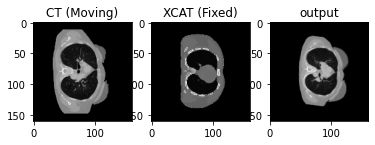

In [24]:
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(x.cpu().detach().numpy()[0, 0, :, :, 120], cmap='gray')
plt.title('CT (Moving)')
plt.subplot(1, 3, 2)
plt.imshow(y.cpu().detach().numpy()[0, 0, :, :, 120], cmap='gray')
plt.title('XCAT (Fixed)')
plt.subplot(1, 3, 3)
plt.imshow(ct_aff.cpu().detach().numpy()[0, 0, :, :, 120], cmap='gray')
plt.title('output')
plt.show()

In [25]:
# MSE before and after registration

In [26]:
import torch.nn as nn
MSE_val = nn.MSELoss()
MSE_before = MSE_val(x, y)
MSE_after = MSE_val(ct_aff, y)
print('MSE berfore: {}, after: {}'.format(MSE_before, MSE_after))

MSE berfore: 3231.59716796875, after: 1071.135498046875


In [27]:
# Save pre-trained model

In [28]:
filename='TransMorph_Affine.pth.tar'
torch.save({'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),},
            'experiments/'+save_dir+filename)

# Inference

In [29]:
# Create model and load weights

In [30]:
config = CONFIGS['TransMorph-Affine']
AffInfer = TransMorph_affine.ApplyAffine()
AffInfer.cuda()
model = TransMorph_affine.SwinAffine(config)
model.cuda()
model.load_state_dict(torch.load('experiments/'+save_dir+'TransMorph_Affine.pth.tar')['state_dict'])

<All keys matched successfully>

In [31]:
# PyTorch Datasets
infer_dir = 'sample_data/'
infer_composed = transforms.Compose([trans.Pad3DIfNeeded((180, 180, 180)),
                                     trans.CenterCropBySize((160, 160, 160)),
                                     trans.NumpyType((np.float32, np.float32)),
                                     ])
infer_set = datasets.CTDataset(glob.glob(infer_dir + '*.pkl'), transforms=infer_composed)
infer_loader = DataLoader(infer_set, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)


In [32]:
# Check files

In [33]:
print(glob.glob(infer_dir + '*.pkl'))

['sample_data\\pt106.pkl', 'sample_data\\pt108.pkl']


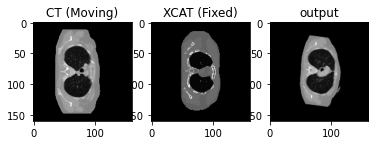

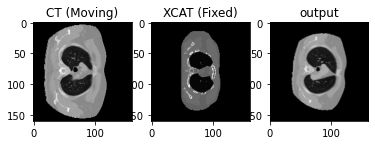

In [34]:
with torch.no_grad():
    for data in infer_loader:
        data = [t.cuda() for t in data]
        x = data[0]
        y = data[1]
        model.eval()
        x_in = torch.cat((x, y), dim=1)
        ct_aff, mat, inv_mats = model(x_in)
        phan = y
        plt.figure()
        plt.subplot(1, 3, 1)
        plt.imshow(x.cpu().detach().numpy()[0, 0, :, :, 130], cmap='gray')
        plt.title('CT (Moving)')
        plt.subplot(1, 3, 2)
        plt.imshow(y.cpu().detach().numpy()[0, 0, :, :, 130], cmap='gray')
        plt.title('XCAT (Fixed)')
        plt.subplot(1, 3, 3)
        plt.imshow(ct_aff.cpu().detach().numpy()[0, 0, :, :, 130], cmap='gray')
        plt.title('output')
        plt.show()